# Imports + Setup

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import cv2
from scipy.stats import norm
from more_itertools import distinct_permutations as idp

import math
import scipy
import random 
import stimuli_gen
import CNN_models
import gc

import tensorflow as tf
import tensorrt
import os


gc.collect()

# For CNN and VGG models
os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Stimuli Info

In [37]:
# Size of stimuli, in multiples of 244 i.e. n224=4 leads to stimuli size of 896x896
n224=1

#interested set sizes for models
setsizes=[1,2,3,4,5,6,7,8,9,10,11,12]


In [38]:
# target and distractor luminance and luminance values for different models (first for IO and ILC, second for CNN, last for VGG)
#This is to balance performance for both features
tang = 20
tcol = 0.8
dang = 10
dcol = 0.651

cnntang = 20
cnntcol = 0.8
cnndang = 10
cnndcol = 0.695

vggtang = 20
vggtcol = 0.8
vggdang = 10
vggdcol = 0.731

In [39]:
# Use stimuli gen code for image-computable models
generator=stimuli_gen.stimuli_gen('conj',tang,dang,tcol,dcol,length=7,n224=n224,N=setsizes[-1])
#all possible combinations for every set size up to your max
settypedictconj, settypedictluminance,settypedictangle=generator.makeallcombs()


In [40]:
# Function for image-computable observers that only need items (IO and ILC)
target,dist_luminance,dist_angle=generator.items()
def stimmaker(list_stim):
    out_array=[]
    for i in list_stim:
        if i==1:
            out_array.append(target)
        if i==2:
            out_array.append(dist_luminance)
        if i==3:
            out_array.append(dist_angle)
    return np.array(out_array)

def noise_adder(imgs,noise):
    return imgs+np.random.normal(0,noise,size=imgs.shape)

# Models and Explanation

## Image Computable

In [41]:
def idealobserver(noise,num_trials=20000):
    noise_string=str(int(noise*255))+'_255'
    try: # if performances were saved load them
        all_perfs=np.load('Data/Tutorial/IO/IO_All_perfs_noise='+noise_string+'.npy')

    except:
        all_perfs=[]
        for allcombstypedict in [settypedictconj, settypedictluminance,settypedictangle]:
            allcombstypedictsquared={}
            pred_io={}
            for i in allcombstypedict.keys(): #Store squared values for each noiseless trial for later calculations
                    allcombstypedictsquared[i]=[]
                    pred_io[i]=[]
                    for k in range(len(allcombstypedict[i])):
                        allcombstypedictsquared[i].append( np.sum(np.square(stimmaker(allcombstypedict[i][k]))))

            
            for l in range(num_trials): # complete many trials 
                thistrial={}
                thistrialsquared={}
                
                
                for i in allcombstypedict.keys(): #Define current trial by adding noise to a random possible trial and save squared values for later calculations
                    thistrial[i]= noise_adder(stimmaker(allcombstypedict[i][random.randint(0,len(allcombstypedict[i])-1)]),noise)
                    thistrialsquared[i]= np.sum(np.square(thistrial[i]))

                for i in allcombstypedict.keys():
                    tpres_like,tabs_like=[],[]
                    for j in range(len(allcombstypedict['p'+str(i[1:])])): #Compare to all target present templates
                        template=stimmaker(allcombstypedict['p'+str(i[1:])][j])
                        mult_term=-2*np.sum(np.multiply(template,thistrial[i]))
                        tpres_like.append(-(allcombstypedictsquared['p'+str(i[1:])][j]+thistrialsquared[i]+mult_term)/(2*noise**2))


                    for j in range(len(allcombstypedict['a'+str(i[1:])])): #Compare to all target absent templates
                        template=stimmaker(allcombstypedict['a'+str(i[1:])][j])
                        mult_term=-2*np.sum(np.multiply(template,thistrial[i]))
                        tabs_like.append(-(allcombstypedictsquared['a'+str(i[1:])][j]+thistrialsquared[i]+mult_term)/(2*noise**2))
                    
                    #Use Log Sum Exp trick to fix issues with over/underflow
                    tpres_like= scipy.special.logsumexp(tpres_like,b=np.ones(shape=len(tpres_like))/len(tpres_like))
                    tabs_like=  scipy.special.logsumexp(tabs_like,b=np.ones(shape=len(tabs_like))/len(tabs_like))

                    if tpres_like>tabs_like: # Choose trial response based on what is more likely
                        pred_io[i].append(1)
                    else:
                        pred_io[i].append(0)

                
                print(str(l), end='\r')
            print('\n')
            perfs=[]
            for i in setsizes:
                perfs.append(np.mean([np.mean(pred_io['pset'+str(i)]),1-np.mean(pred_io['aset'+str(i)])]))
            all_perfs.append(perfs)
    np.save('Data/Tutorial/IO/IO_All_perfs_noise='+noise_string+'.npy',all_perfs)
    conj=all_perfs[0]
    luminance=all_perfs[1]
    angle=all_perfs[2]

        
    return conj,luminance,angle
        






        


In [42]:
def ILC(noise,num_trials=20000):
    noise_string=str(int(noise*255))+'_255'
    try: # if performances were saved load them
        all_perfs=np.load('Data/Tutorial/ILC/ILC_All_perfs_noise='+noise_string+'.npy')

    except:
        all_perfs=[]
        type_of_search=1
        for allcombstypedict in [settypedictconj, settypedictluminance,settypedictangle]:
            angle_temps={}
            luminance_temps={}
            target_temps={}

            angle_squareds={}
            luminance_squareds={}
            target_squareds={}

            all_max_likes={}

            
            for i in allcombstypedict.keys(): #Store squared and normal values for each item type (target, angle distractor, luminance distractor)
                angle_temps[str(i[1:])]=stimmaker(3*np.ones(int(i[4:])))
                luminance_temps[str(i[1:])]=stimmaker(2*np.ones(int(i[4:])))
                target_temps[str(i[1:])]=stimmaker(np.ones(int(i[4:])))
                
                angle_squareds[str(i[1:])]=np.sum(np.sum(np.square(angle_temps[str(i[1:])]),axis=1),axis=1)
                luminance_squareds[str(i[1:])]=np.sum(np.sum(np.square(luminance_temps[str(i[1:])]),axis=1),axis=1)
                target_squareds[str(i[1:])]=np.sum(np.sum(np.square(target_temps[str(i[1:])]),axis=1),axis=1)
                
                all_max_likes[i]=[]


            for l in range(num_trials): # complete many trials 
                thistrial={}
                thistrialsquared={}
                for i in allcombstypedict.keys(): #Define current trial by adding noise to a random possible trial and save squared values for later calculations
                    thistrial[i]= noise_adder(stimmaker(allcombstypedict[i][random.randint(0,len(allcombstypedict[i])-1)]),noise)
                    thistrialsquared[i]= np.sum(np.sum(np.square(thistrial[i]),axis=1),axis=1)
                    
                
                for i in allcombstypedict.keys():
                    if type_of_search==3: # compare to target and angle distractor, take the max location
                        a=thistrialsquared[i]+angle_squareds[str(i[1:])]-2*np.sum(np.sum(np.multiply(thistrial[i],angle_temps[str(i[1:])]),axis=1),axis=1)
                        b=thistrialsquared[i]+target_squareds[str(i[1:])]-2*np.sum(np.sum(np.multiply(thistrial[i],target_temps[str(i[1:])]),axis=1),axis=1)
                        all_max_likes[i].append(np.exp(np.amax(-(b-a)/(2*noise**2))))
                    if type_of_search==2: # compare to target and luminance distractor, take the max location
                        a=thistrialsquared[i]+luminance_squareds[str(i[1:])]-2*np.sum(np.sum(np.multiply(thistrial[i],luminance_temps[str(i[1:])]),axis=1),axis=1)
                        b=thistrialsquared[i]+target_squareds[str(i[1:])]-2*np.sum(np.sum(np.multiply(thistrial[i],target_temps[str(i[1:])]),axis=1),axis=1)
                        all_max_likes[i].append(np.exp(np.amax(-(b-a)/(2*noise**2))))
                    if type_of_search==1: # compare to target and both distractors, take the max location
                        a=thistrialsquared[i]+luminance_squareds[str(i[1:])]-2*np.sum(np.sum(np.multiply(thistrial[i],luminance_temps[str(i[1:])]),axis=1),axis=1)
                        b=thistrialsquared[i]+angle_squareds[str(i[1:])]-2*np.sum(np.sum(np.multiply(thistrial[i],angle_temps[str(i[1:])]),axis=1),axis=1)
                        c=thistrialsquared[i]+target_squareds[str(i[1:])]-2*np.sum(np.sum(np.multiply(thistrial[i],target_temps[str(i[1:])]),axis=1),axis=1)
                        all_max_likes[i].append(np.amax(np.log(2)-c/(2*noise**2)-np.log(np.exp(-a/(2*noise**2))+np.exp(-b/(2*noise**2)))))
                print(str(l), end='\r')
            print('\n')
            perfs=[]
            trial_actual=np.concatenate((np.ones(num_trials),np.zeros(num_trials)))
            for i in setsizes:        
                fpr, tpr, _ = metrics.roc_curve(trial_actual,np.concatenate((all_max_likes['pset'+str(i)],all_max_likes['aset'+str(i)]))) # find the optimal threshold to get a performance

                perfs.append(np.amax(((1-fpr)+tpr)/2))
            all_perfs.append(perfs)
            type_of_search+=1
    np.save('Data/Tutorial/ILC/ILC_All_perfs_noise='+noise_string+'.npy',all_perfs)
    conj=all_perfs[0]
    luminance=all_perfs[1]
    angle=all_perfs[2]

    return conj,luminance,angle


In [43]:
def smallCNN(noise,nmodels=10,n10000=4):
    try:
        all_perfs=np.load('Data/Tutorial/Fully_trained/Perfs/noise_'+str(noise)+'.npy')
    except:
        all_perfs=[]
        for searchtype in ['conj','luminance','angle']:
            performance=[]
            for i in range(1,nmodels+1): # train many cnns 
                model=CNN_models.small_CNN()
                generator=stimuli_gen.stimuli_gen(searchtype,cnntang,cnndang,cnntcol,cnndcol,length=7,n224=1)
                model=CNN_models.train_Classifier(model,generator.trainsetmaker,generator.testsetmaker,noise)
                model.save('Data/Tutorial/Fully_trained/Networks/'+str(searchtype)+'_'+str(noise)+'_'+str(i)+'.h5')
                performance.append(CNN_models.testSmall(model,setsizes,noise,n10000,generator.testsetmaker)) # test cnns with n10000*10000 images per set size
            all_perfs.append(performance)
        np.save('Data/Tutorial/Fully_trained/Perfs/noise_'+str(noise)+'.npy',all_perfs)


    return all_perfs[0],all_perfs[1],all_perfs[2]



In [44]:
def VGG_transfer(noise,nmodels=10,n10000=4):
    try:
        all_perfs=np.load('Data/Tutorial/VGG/Perfs/noise_'+str(noise)+'.npy')
    except:
        all_perfs=[]
        for searchtype in ['conj','luminance','angle']:
            performance=[]
            for i in range(1,nmodels+1): # train many cnns 
                model=CNN_models.VGG_for_transfer()
                generator=stimuli_gen.stimuli_gen(searchtype,vggtang,vggdang,vggtcol,vggdcol,length=7,n224=1)
                model=CNN_models.train_large(model,generator.trainsetmaker,generator.testsetmaker,noise)
                model.save('Data/Tutorial/VGG/Networks/'+str(searchtype)+'_'+str(noise)+'_'+str(i)+'.h5')
                performance.append(CNN_models.testLarge(model,setsizes,noise,n10000,generator.testsetmaker)) # test cnns with n10000*10000 images per set size
            all_perfs.append(performance)
        np.save('Data/Tutorial/VGG/Perfs/noise_'+str(noise)+'.npy',all_perfs)


    return all_perfs[0],all_perfs[1],all_perfs[2]



    

## Feature Extracted

In [45]:
def sdt(d,simulation=False,numtrials=20000):
    if simulation==False:
        conjd=d/np.sqrt(2)
        
        def FP(x,n,d): #False positive rate
            return (1-norm.cdf(x)**n)
        def HR(x,n,d): # Hit Rate
            return 1-(norm.cdf(x-d)*norm.cdf(x)**(n-1))
        def PC(x,n,d): # Performance
            return 0.5*(1-FP(x,n,d)+HR(x,n,d))
        def optimal(x,*data): # function to find optimal threshold
            n,d=data
            return n-np.exp(x*d-(d**2)/2)-(n-1)*(scipy.special.erf((x-d)/np.sqrt(2))+1)/(scipy.special.erf((x)/np.sqrt(2))+1)


        conj_data=[]
        feature_data=[]
        
        for n in setsizes:
            conj_data.append(PC(scipy.optimize.fsolve(optimal,conjd/2,args=(n,conjd))[0],n,conjd))
            feature_data.append(PC(scipy.optimize.fsolve(optimal,d/2,args=(n,d))[0],n,d))
        

    if simulation==True:
        
        trialactivations={} # get activations for trials
        for i in setsizes:
            trialactivations['aset'+str(i)]=np.random.normal(0,1,size=(numtrials,i)) #absent activations
            a=np.random.normal(d,1,size=(numtrials,1)) #present activations
            b=np.random.normal(0,1,size=(numtrials,i-1)) #absent activations
            trialactivations['pset'+str(i)]=np.concatenate((a,b),axis=-1)

        trial_actual=np.concatenate((np.ones(numtrials),np.zeros(numtrials)))
        feature_data=[]
        for i in setsizes:        
            fpr, tpr, zz = metrics.roc_curve(trial_actual,np.concatenate((np.amax(trialactivations['pset'+str(i)],axis=-1),np.amax(trialactivations['aset'+str(i)],axis=-1)))) # Get a performance using the optimal threshold

            feature_data.append(np.amax(((1-fpr)+tpr)/2))
        
        trialactivations={} # get activations for trials
        for i in setsizes:
            trialactivations['aset'+str(i)]=np.random.normal(0,1,size=(numtrials,i)) #absent activations
            a=np.random.normal(d/np.sqrt(2),1,size=(numtrials,1)) #present activations
            b=np.random.normal(0,1,size=(numtrials,i-1)) #absent activations
            trialactivations['pset'+str(i)]=np.concatenate((a,b),axis=-1)

        trial_actual=np.concatenate((np.ones(numtrials),np.zeros(numtrials)))
        conj_data=[]
        for i in setsizes:        
            fpr, tpr, zz = metrics.roc_curve(trial_actual,np.concatenate((np.amax(trialactivations['pset'+str(i)],axis=-1),np.amax(trialactivations['aset'+str(i)],axis=-1)))) # Get a performance using the optimal threshold

            conj_data.append(np.amax(((1-fpr)+tpr)/2))
        
    return conj_data,feature_data,feature_data
        

            
    

In [46]:
def capacitySDT(d1,bf,bc,simulation=False,numtrials=20000):
    conjd1=d1/np.sqrt(2)
    if simulation==False:
        def FP(x,n,d): #False positive rate
            return (1-norm.cdf(x)**n)
        def HR(x,n,d): # Hit Rate
            return 1-(norm.cdf(x-d)*norm.cdf(x)**(n-1))
        def PC(x,n,d): # Performance
            return 0.5*(1-FP(x,n,d)+HR(x,n,d))
        def optimal(x,*data): # function to find optimal threshold
            n,d=data
            return n-np.exp(x*d-(d**2)/2)-(n-1)*(scipy.special.erf((x-d)/np.sqrt(2))+1)/(scipy.special.erf((x)/np.sqrt(2))+1)

        conj_data=[]
        feature_data=[]
        for n in setsizes:
            d=(d1)/(n**(bf/2))
            conjd=(conjd1)/(n**(bc/2))
            conj_data.append(PC(scipy.optimize.fsolve(optimal,conjd/2,args=(n,conjd))[0],n,conjd))
            feature_data.append(PC(scipy.optimize.fsolve(optimal,d/2,args=(n,d))[0],n,d))


    if simulation==True:
            
            trialactivations={} # get activations for trials
            for i in setsizes:
                trialactivations['aset'+str(i)]=np.random.normal(0,1,size=(numtrials,i)) #absent activations
                a=np.random.normal((d1)/(i**(bf/2)),1,size=(numtrials,1)) #present activations
                b=np.random.normal(0,1,size=(numtrials,i-1)) #absent activations
                trialactivations['pset'+str(i)]=np.concatenate((a,b),axis=-1)

            trial_actual=np.concatenate((np.ones(numtrials),np.zeros(numtrials)))
            feature_data=[]
            for i in setsizes:        
                fpr, tpr, zz = metrics.roc_curve(trial_actual,np.concatenate((np.amax(trialactivations['pset'+str(i)],axis=-1),np.amax(trialactivations['aset'+str(i)],axis=-1)))) # Get a performance using the optimal threshold

                feature_data.append(np.amax(((1-fpr)+tpr)/2))
            
            trialactivations={} # get activations for trials
            for i in setsizes:
                trialactivations['aset'+str(i)]=np.random.normal(0,1,size=(numtrials,i)) #absent activations
                a=np.random.normal((conjd1)/(i**(bc/2)),1,size=(numtrials,1)) #present activations
                b=np.random.normal(0,1,size=(numtrials,i-1)) #absent activations
                trialactivations['pset'+str(i)]=np.concatenate((a,b),axis=-1)

            trial_actual=np.concatenate((np.ones(numtrials),np.zeros(numtrials)))
            conj_data=[]
            for i in setsizes:        
                fpr, tpr, zz = metrics.roc_curve(trial_actual,np.concatenate((np.amax(trialactivations['pset'+str(i)],axis=-1),np.amax(trialactivations['aset'+str(i)],axis=-1)))) # Get a performance using the optimal threshold

                conj_data.append(np.amax(((1-fpr)+tpr)/2))
            
    return conj_data,feature_data,feature_data
            

In [47]:
def guidedSearch(d,k,hL_f,hL_c,g_f,g_c,simulation=False,numtrials=20000):
    if simulation == True:
        def guidedsim(d,k,hL,g):
            trialactivations={} # get activations for trials
            for i in setsizes:
                trialactivations['aset'+str(i)]=np.random.normal(0,1,size=(numtrials,i)) #absent activations
                a=np.random.normal(d,1,size=(numtrials,1)) #present activations
                b=np.random.normal(0,1,size=(numtrials,i-1)) #absent activations
                trialactivations['pset'+str(i)]=np.concatenate((a,b),axis=-1)
            
            pred={} #get a prediction for each trial
            tmore={}
            tles={}
            for i in trialactivations.keys():
                pred[i]=[]
                for j in trialactivations[i]:
                    
                    temp=list(j[np.where(j>=hL)[0]]) #store the activations for the trial above threshold
                    if i[0]=='a': # target absent trials
                        if len(temp)<=k: # if all items above threshold are searched, predict target absent
                            pred[i].append(0) 
                        else: # if not all are searched, guess
                            pred[i].append(np.random.choice([0,1],p=[1-g,g]))

                    if i[0]=='p': # target present trials
                        temp.sort(reverse=True) #order the activations
                        if j[0] in temp: #If the target is above the threshold
                            if temp.index(j[0])+1<=k: # and the target is one of the k highest activations, predict target present
                                pred[i].append(1)
                            else: # and the at least k distractor activations are above the target, predict target present
                                pred[i].append(np.random.choice([0,1],p=[1-g,g]))
                        else: # If the target is below the threshold
                            if len(temp)<=k:#and all items above threshold are searched, predict target absent
                                pred[i].append(0)
                            else: #and there are more than k items above threshold, guess
                                pred[i].append(np.random.choice([0,1],p=[1-g,g]))

            perfs=[]
            hr=[]
            fp=[]

            for i in setsizes:
                hr.append(np.mean(pred['pset'+str(i)]))
                fp.append(np.mean(pred['aset'+str(i)]))
                perfs.append(0.5*(hr[-1]+1-fp[-1]))
            return perfs
        conj_data=guidedsim(d/np.sqrt(2),k,hL_c,g_c)
        feature_data=guidedsim(d,k,hL_f,g_f)

    if simulation == False:


        def nck(n,k): # n choose k function
            return math.factorial(n)/(math.factorial(k)*math.factorial(n-k))
        def phi(ins): # PDF of gaussian
                return np.exp(-0.5*(ins)**2)/np.sqrt(2*np.pi)

        def FP(hL,g,k,N): # False positive rate
            bdis=0
            p=1-norm.cdf(hL)
            for i in range(k+1,N+1):
                bdis+= nck(N,i) * p**i * (1-p)**(N-i)
            return (g) * (bdis)


        def HR(hL,g,k,d,N): # Hit Rate
            bdis=0
            p=1-norm.cdf(hL)
            for i in range(k+1,N):
                bdis+= nck(N-1,i) * p**i * (1-p)**(N-1-i)
            prob_target_lessthan_hL=norm.cdf(hL-d) * (g) * (bdis) # for when target is under threshold


            bdis=0
            for i in range(k,N):
                bdis+=nck(N-1,i)*scipy.integrate.quad(lambda x: ((1-norm.cdf(x))**(i))*(norm.cdf(x)**(N-1-i))*phi(x-d), hL, np.inf)[0]
            prob_target_morethan_hL=(1-norm.cdf(hL-d))-(1-g)*bdis # for when target is over threshold

            return prob_target_lessthan_hL+prob_target_morethan_hL

        conj_data=[]
        feature_data=[]

        for i in setsizes:
            hr=HR(hL_f,g_f,k,d,i)
            fp=FP(hL_f,g_f,k,i)
            feature_data.append(0.5*(hr+1-fp))
            hr=HR(hL_c,g_c,k,d/np.sqrt(2),i)
            fp=FP(hL_c,g_c,k,i)
            conj_data.append(0.5*(hr+1-fp))

    return conj_data,feature_data,feature_data
        
        

# Outputs and Example

In [48]:
# all models performance, fit to set size 1 performance = .98
# Image Computable (Bayes)
conj_io_final_perfs,luminance_io_final_perfs,angle_io_final_perfs=idealobserver(85/255)
conjilcperfs,luminanceilcperfs,angleilcperfs=ILC(85/255)

# Image Computable (CNN)
FTconj_all_presence,FTluminance_all_presence,FTangle_all_presence=smallCNN(50)
VGGconj_all_presence,VGGluminance_all_presence,VGGangle_all_presence=VGG_transfer(18)

#Feature Extracted 
conj_sdt_data,feature_sdt_data,feature_sdt_data=sdt(4.25,simulation=False)
conj_capacitySDT_data,feature_capacitySDT_data,feature_capacitySDT_data=capacitySDT(4.4,0.05,0.8,simulation=True) # Uses capacity fits from (Poder, 2019)
conj_guided_data,feature_guided_data,feature_guided_data=guidedSearch(2, 5, .4, .4, 0.2, 0.2) # Uses 5 as a reasonable search count, sets seperate values for feature and conjunction as the same

In [49]:
def sse(a):
    return a[0]-a[-1]
# Feature Set Size Effects
print(sse(np.mean(FTangle_all_presence,axis=0)))
print(sse(np.mean(VGGangle_all_presence,axis=0)))
print(sse(feature_guided_data))
print(sse(angle_io_final_perfs))
print(sse(angleilcperfs))
print(sse(feature_capacitySDT_data))
print(sse(feature_sdt_data))


0.031397502124309584
0.04865499436855314
0.024076289341789736
0.03397500000000009
0.035149999999999904
0.044825000000000115
0.032764919792464764


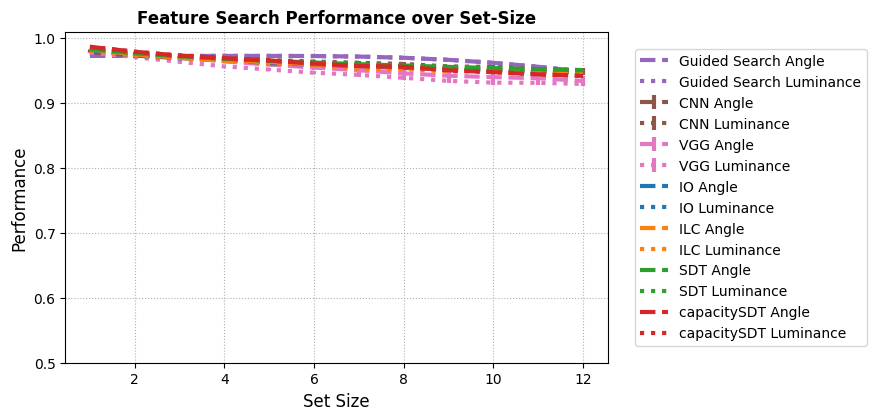

In [50]:
plt.figure(figsize=(7,4.3))

line_style2='dashed'
line_style3='dotted'

plt.errorbar(setsizes,feature_guided_data,label="Guided Search Angle",color='C4', elinewidth=3, linewidth=3, ls=line_style2)
plt.errorbar(setsizes,feature_guided_data,label="Guided Search Luminance",color='C4', elinewidth=3, linewidth=3, ls=line_style3)

plt.errorbar(setsizes,np.mean(FTangle_all_presence,axis=0),yerr=np.std(FTangle_all_presence,axis=0)/np.sqrt(5),label='CNN Angle',color='C5', elinewidth=3, linewidth=3, ls=line_style2)
plt.errorbar(setsizes,np.mean(FTluminance_all_presence,axis=0),yerr=np.std(FTluminance_all_presence,axis=0)/np.sqrt(5),label='CNN Luminance',color='C5', elinewidth=3, linewidth=3, ls=line_style3)

plt.errorbar(setsizes,np.mean(VGGangle_all_presence,axis=0),yerr=np.std(VGGangle_all_presence,axis=0)/np.sqrt(5),label='VGG Angle',color='C6', elinewidth=3, linewidth=3, ls=line_style2)
plt.errorbar(setsizes,np.mean(VGGluminance_all_presence,axis=0),yerr=np.std(VGGluminance_all_presence,axis=0)/np.sqrt(5),label='VGG Luminance',color='C6', elinewidth=3, linewidth=3, ls=line_style3)

plt.errorbar(setsizes,angle_io_final_perfs,label="IO Angle",color='C0', elinewidth=3, linewidth=3, ls=line_style2)
plt.errorbar(setsizes,luminance_io_final_perfs,label="IO Luminance",color='C0', elinewidth=3, linewidth=3, ls=line_style3)

plt.errorbar(setsizes,angleilcperfs,label="ILC Angle",color='C1', elinewidth=3, linewidth=3, ls=line_style2)
plt.errorbar(setsizes,luminanceilcperfs,label="ILC Luminance",color='C1', elinewidth=3, linewidth=3, ls=line_style3)

plt.errorbar(setsizes,feature_sdt_data,label="SDT Angle",color='C2', elinewidth=3, linewidth=3, ls=line_style2)
plt.errorbar(setsizes,feature_sdt_data,label="SDT Luminance",color='C2', elinewidth=3, linewidth=3, ls=line_style3)

plt.errorbar(setsizes,feature_capacitySDT_data,label="capacitySDT Angle",color='C3', elinewidth=3, linewidth=3, ls=line_style2)
plt.errorbar(setsizes,feature_capacitySDT_data,label="capacitySDT Luminance",color='C3', elinewidth=3, linewidth=3, ls=line_style3)

plt.ylim([.5,1.01])
plt.grid(linestyle=':')

plt.legend(loc=(1.05,0.05))
plt.title('Feature Search Performance over Set-Size', fontweight="bold")
plt.ylabel('Performance', fontsize='large')
plt.xlabel('Set Size', fontsize='large')
plt.show()



In [51]:
# Conjunction Set Size Effects

print(sse(np.mean(FTconj_all_presence,axis=0)))
print(sse(np.mean(VGGconj_all_presence,axis=0)))
print(sse(feature_guided_data))
print(sse(conj_io_final_perfs))
print(sse(conjilcperfs))
print(sse(feature_capacitySDT_data))
print(sse(feature_sdt_data))

0.06824999898672102
0.09494499862194061
0.024076289341789736
0.04852500000000004
0.04512499999999997
0.044825000000000115
0.032764919792464764


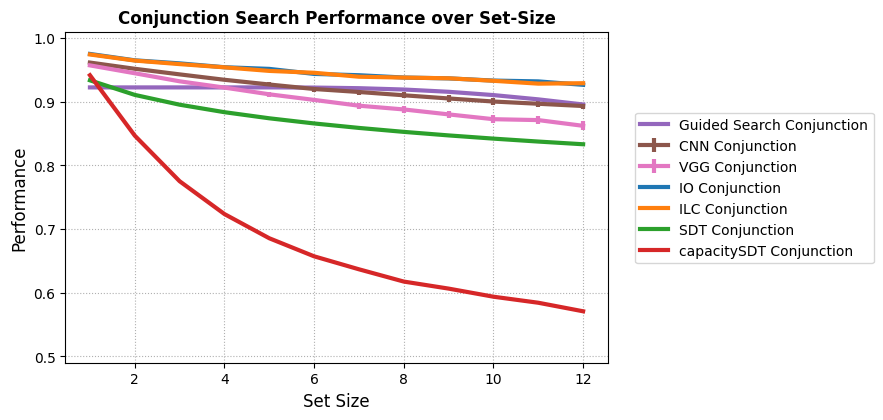

In [52]:
plt.figure(figsize=(7,4.3))
line_style2='solid'



plt.errorbar(setsizes,conj_guided_data,label="Guided Search Conjunction",color='C4', elinewidth=3, linewidth=3, ls=line_style2)

plt.errorbar(setsizes,np.mean(FTconj_all_presence,axis=0),yerr=np.std(FTconj_all_presence,axis=0)/np.sqrt(5),label='CNN Conjunction',color='C5', elinewidth=3, linewidth=3, ls=line_style2)

plt.errorbar(setsizes,np.mean(VGGconj_all_presence,axis=0),yerr=np.std(VGGconj_all_presence,axis=0)/np.sqrt(5),label='VGG Conjunction',color='C6', elinewidth=3, linewidth=3, ls=line_style2)

plt.errorbar(setsizes,conj_io_final_perfs,label="IO Conjunction",color='C0', elinewidth=3, linewidth=3, ls=line_style2)

plt.errorbar(setsizes,conjilcperfs,label="ILC Conjunction",color='C1', elinewidth=3, linewidth=3, ls=line_style2)

plt.errorbar(setsizes,conj_sdt_data,label="SDT Conjunction",color='C2', elinewidth=3, linewidth=3, ls=line_style2)

plt.errorbar(setsizes,conj_capacitySDT_data,label="capacitySDT Conjunction",color='C3', elinewidth=3, linewidth=3, ls=line_style2)
plt.ylim([.49,1.01])
plt.grid(linestyle=':')

plt.legend(loc=(1.05,0.3))
plt.title('Conjunction Search Performance over Set-Size', fontweight="bold")
plt.ylabel('Performance', fontsize='large')
plt.xlabel('Set Size', fontsize='large')
plt.show()

